In [36]:
from tslearn.clustering import TimeSeriesKMeans
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlopen
import json
import numpy as np

# cluster on house price

In [23]:
df = pd.read_csv('Data_Files/price_by_state_cleaned.csv')

split_date = '2020-01-31'  # Choose the date where to split the data
train = df[df['Unnamed: 0'] < split_date]
train = train.drop(columns=['Unnamed: 0'])
test = df[df['Unnamed: 0'] >= split_date]
test = test.drop(columns=['Unnamed: 0'])

# find difference before transposing
train = train.pct_change()
# print(train)
train = train.values.T
train = train[:, 1:]
print(train)

[[0.0033613  0.00452337 0.00977468 ... 0.00568744 0.00615746 0.00634244]
 [0.00054343 0.00026343 0.00130707 ... 0.00418319 0.00493243 0.00534438]
 [0.00216609 0.00262006 0.00531199 ... 0.00387765 0.00528324 0.00647694]
 ...
 [0.00327078 0.00462577 0.00987294 ... 0.00091018 0.00199234 0.00260011]
 [0.00167447 0.00262531 0.00514507 ... 0.00366406 0.00520889 0.00638599]
 [0.         0.         0.         ... 0.00521543 0.00541199 0.00682817]]


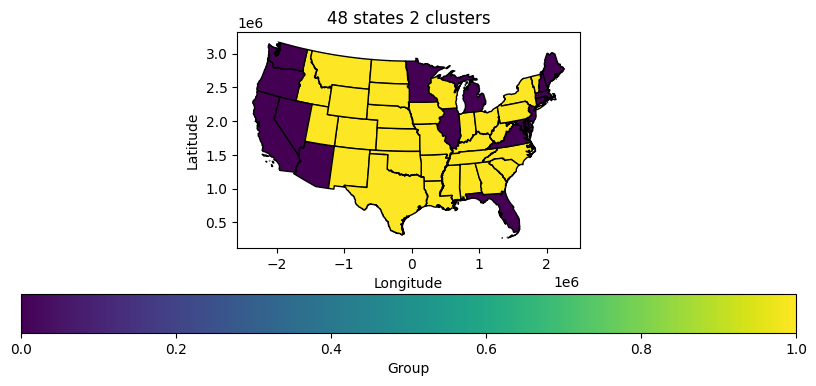

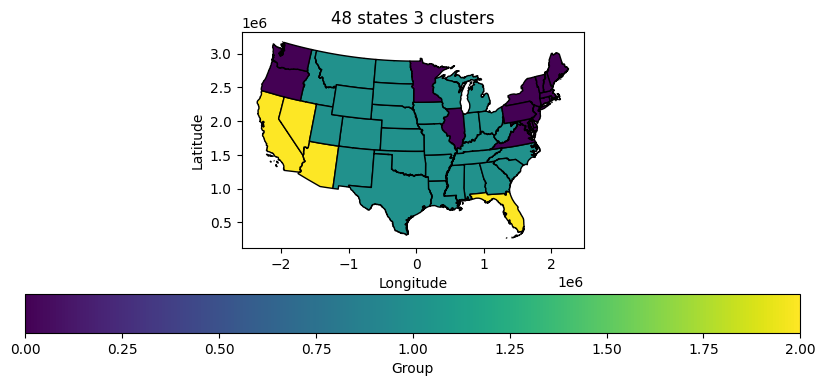

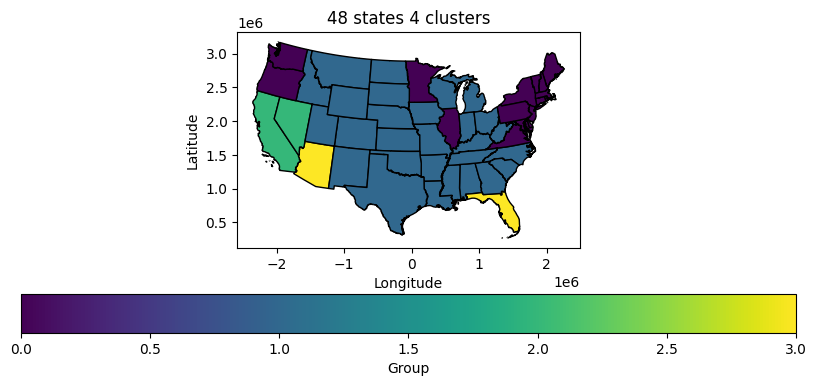

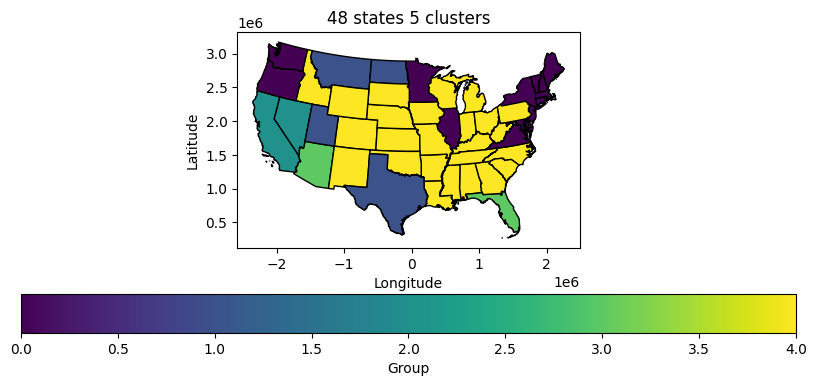

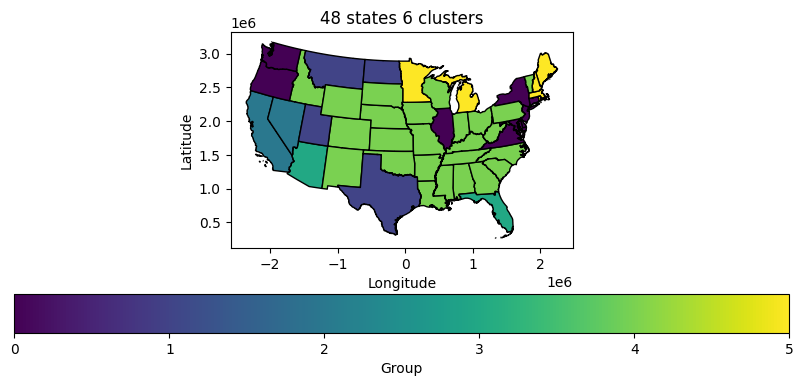

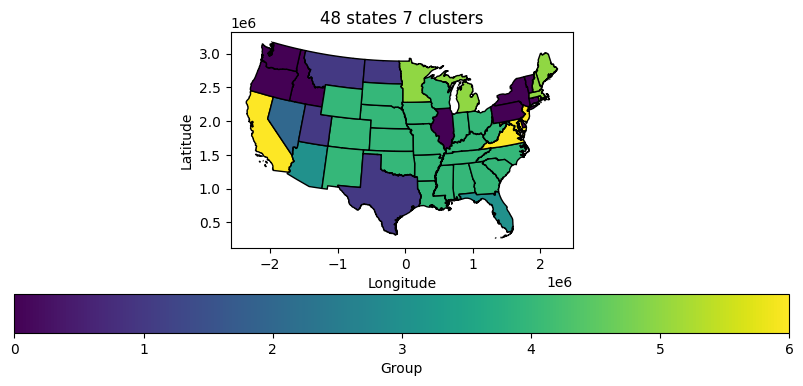

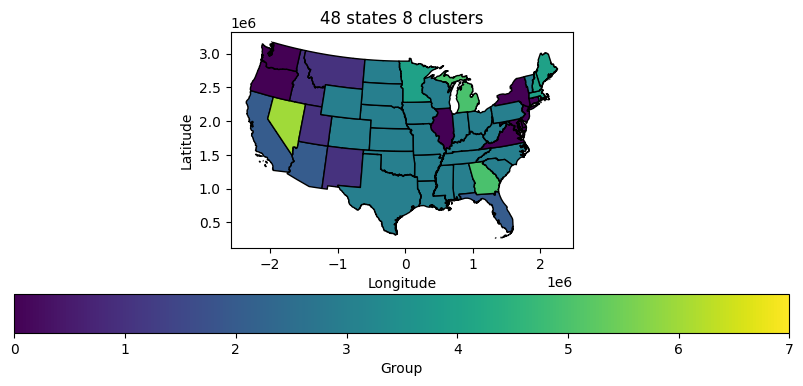

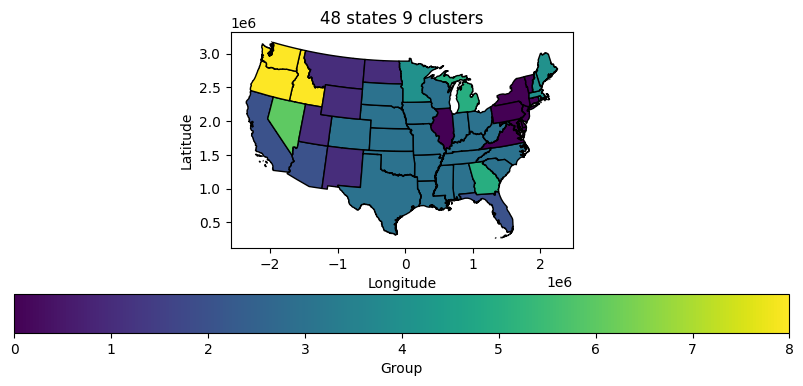

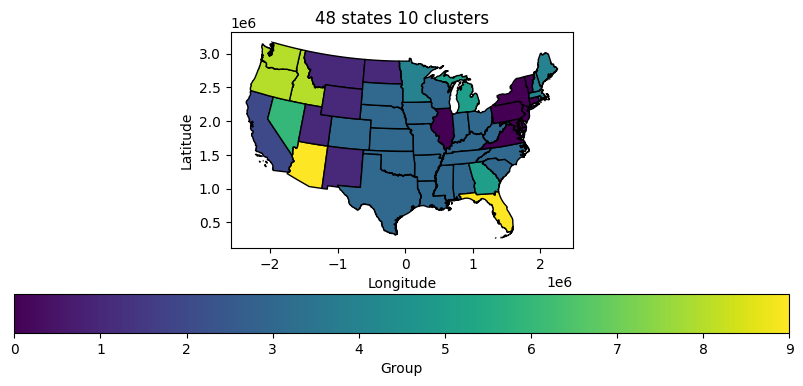

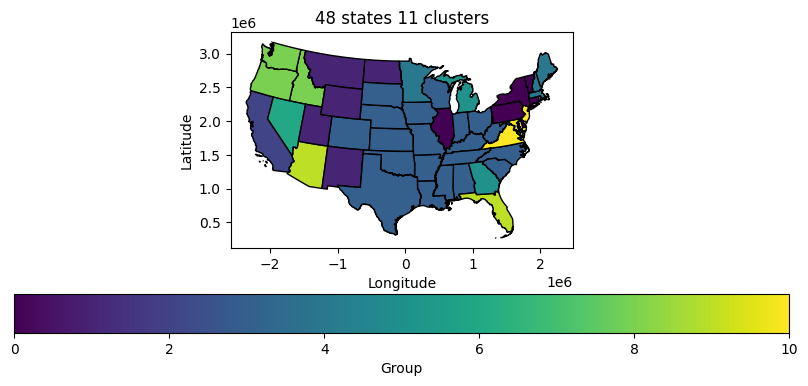

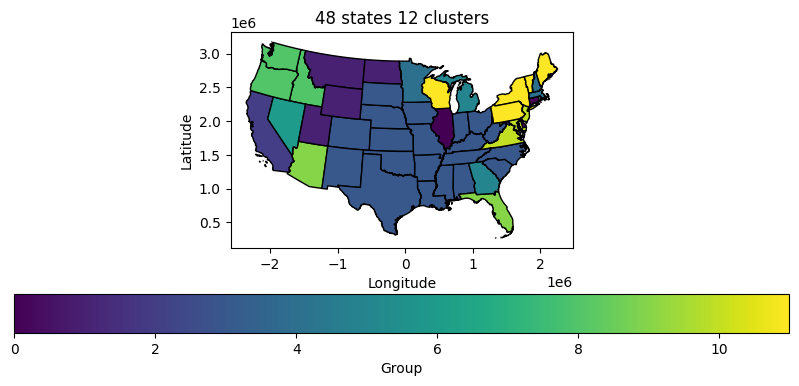

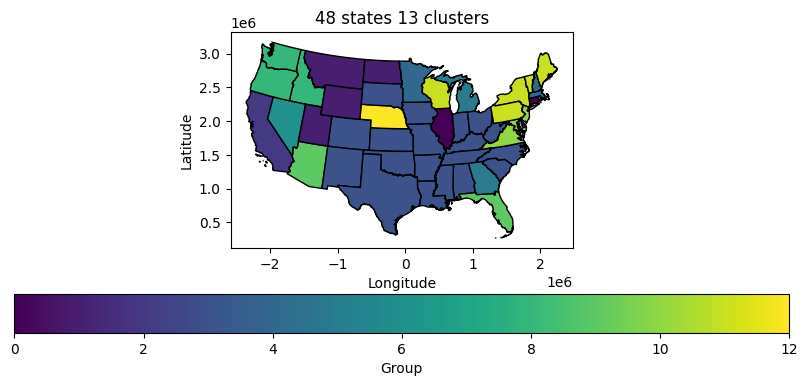

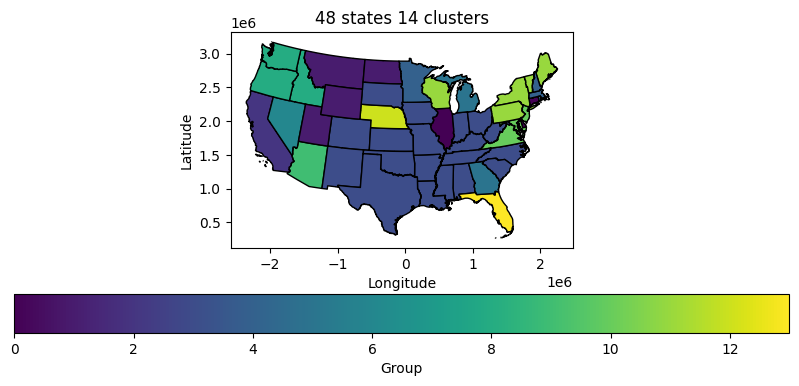

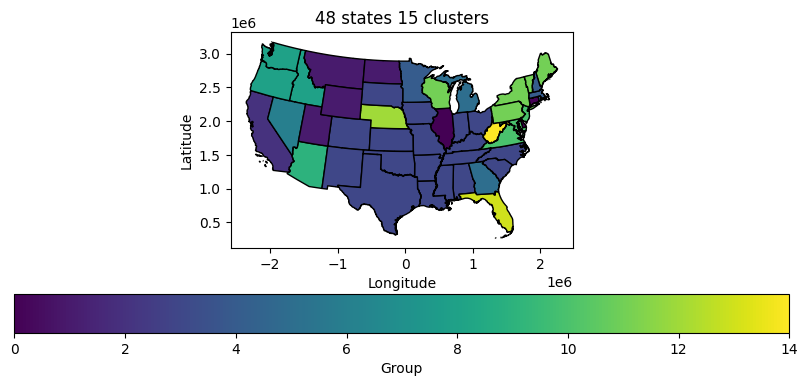

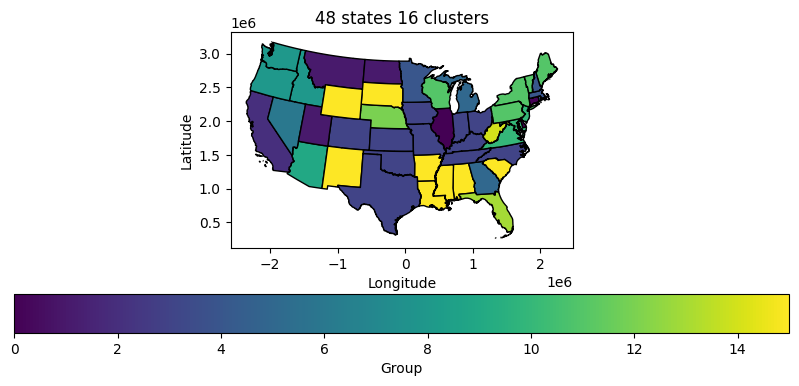

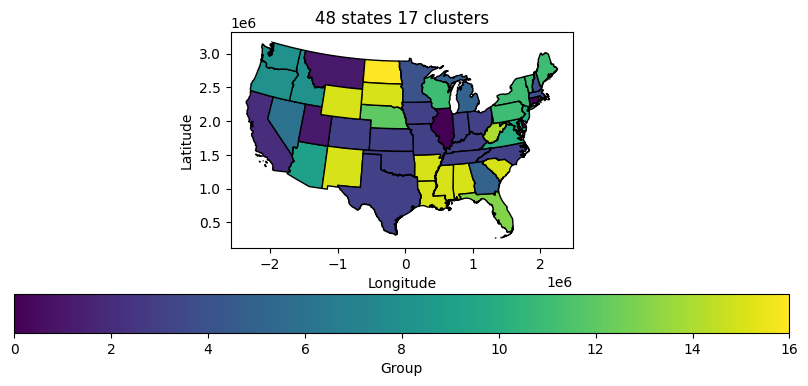

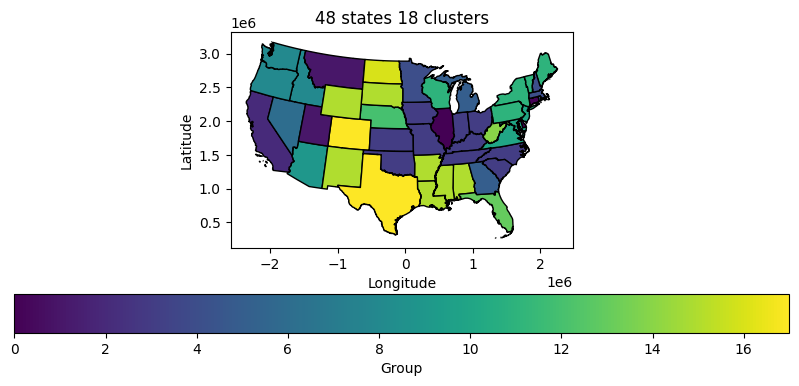

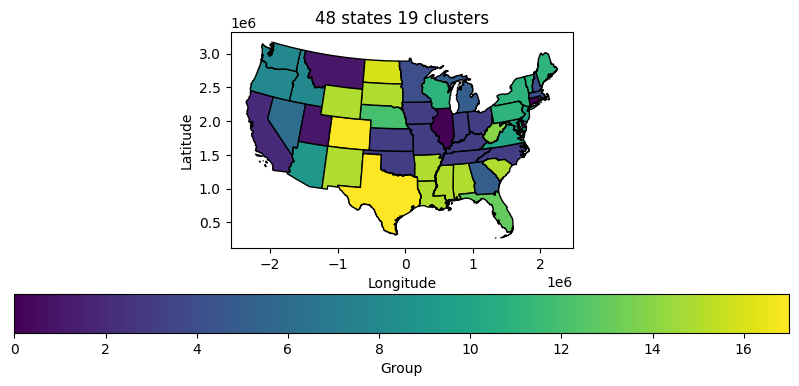

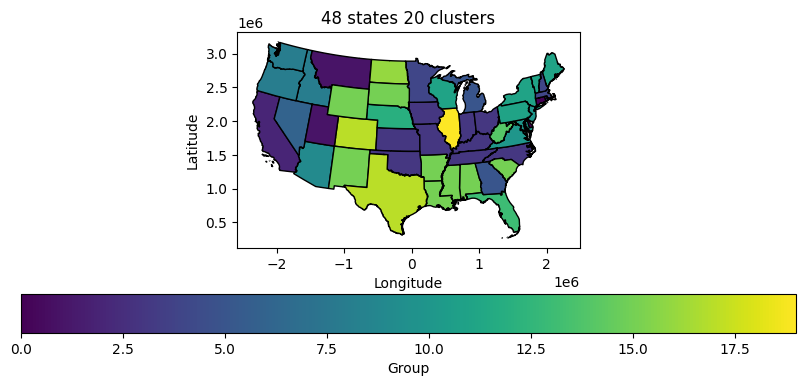

In [31]:
for j in range(2, 21):
    # Kmeans with i clusters
    km = TimeSeriesKMeans(n_clusters=j, max_iter=1000, random_state=0)
    pred = km.fit_predict(train)

    state_names = df.columns.tolist()[1:]
    plot_df = pd.DataFrame({
        "State": state_names,
        "Number": pred
    })

    # compute cluster
    cluster = {}
    for i in range(j):
        state_with_ = plot_df[plot_df["Number"] == i]["State"]
        cluster[i] = state_with_.values.tolist()

    # Convert group_data to DataFrame
    grouped_states = []
    for group, states in cluster.items():
        for state in states:
            grouped_states.append({'Group': group, 'State': state.lower()})

    grouped_df = pd.DataFrame(grouped_states)
    fips = pd.read_csv('Data_Files/fips.csv')

    # Merge grouped states with their codes
    fips['STATE'] = fips['STATE'].str.lower()
    fips = fips.rename(columns={'STATE': 'State'})
    merged_df = pd.merge(grouped_df, fips, on='State', how='left')
    merged_df['CODE'] = merged_df['CODE'].astype(str).str.zfill(2)
    merged_df = merged_df.rename(columns={'CODE': 'STATEFP'})

    gdf = gpd.read_file("Data_Files/county_data.gpkg")
    gdf = pd.merge(gdf, merged_df, on='STATEFP', how='left')

    # new dataframe that dissolves all counties within each state and drop regions with certain codes
    new_counties = gdf.dissolve(by="STATEFP", aggfunc="first")
    new_counties = new_counties.drop(["02", "15", "60", "66", "69", "72", "78"])
    new_counties.to_crs(5071, inplace=True)
    fig, ax = plt.subplots(1, figsize=(10, 4))
    base = new_counties.plot(column='Group', legend=True, legend_kwds={'label': "Group",
                                        'orientation': "horizontal"}, edgecolor="black", ax=ax, linewidth=1)
    ax.set_title(f"48 states {j} clusters")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.show()

# cluster by demographic data

In [77]:
import data_loader
data = data_loader.load_data()
df = pd.read_csv('Data_Files/price_by_state_cleaned.csv')
# print(data)
# print('keys', data.values)

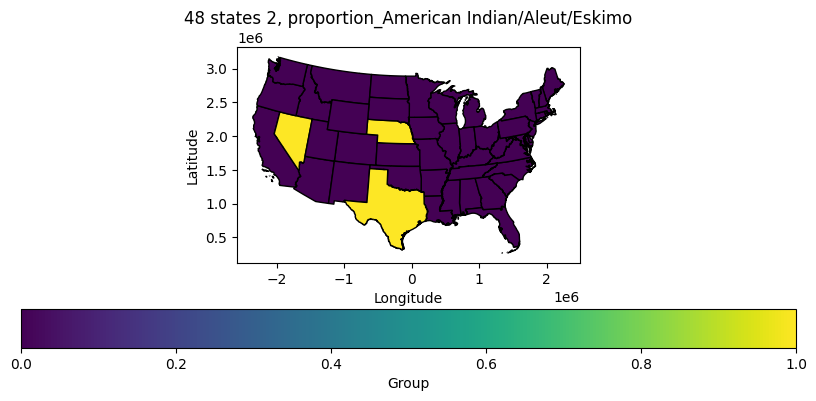

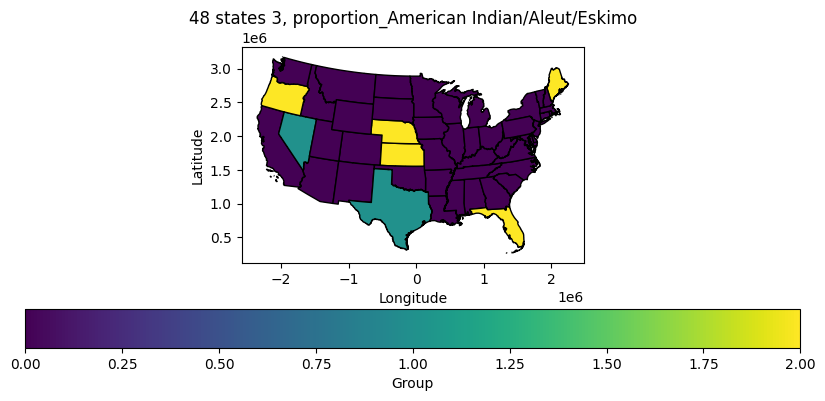

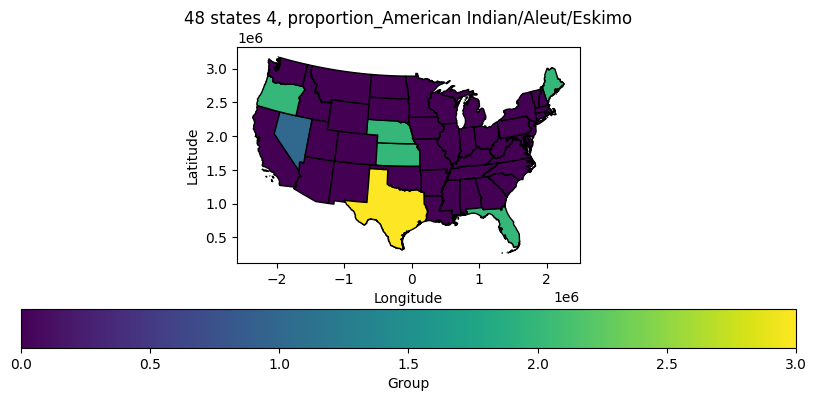

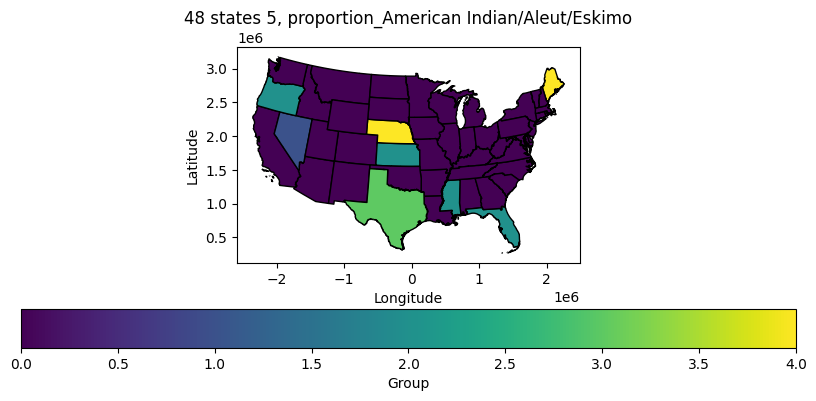

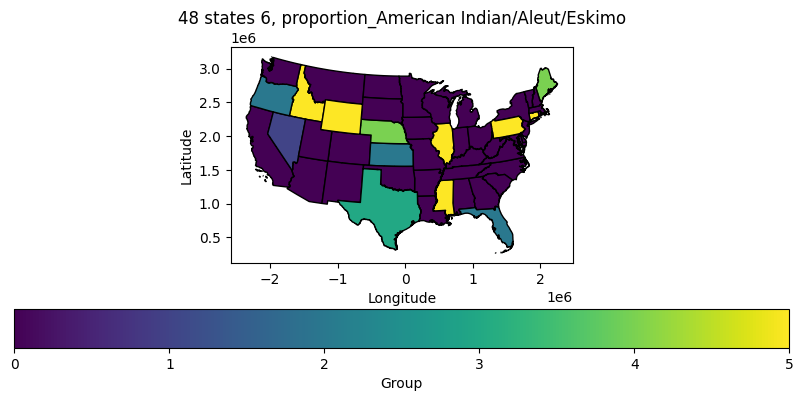

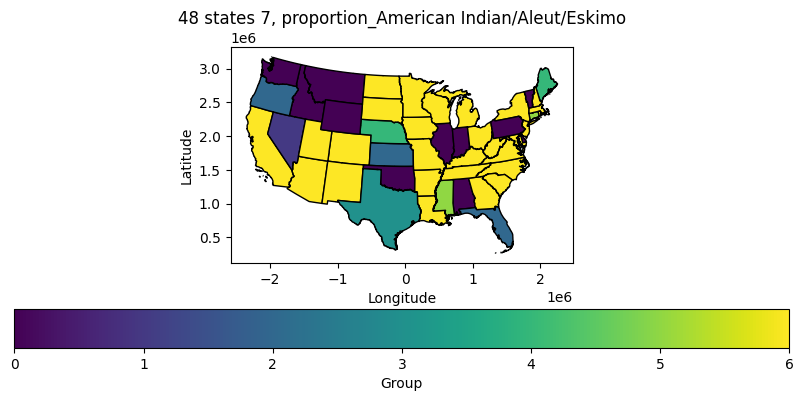

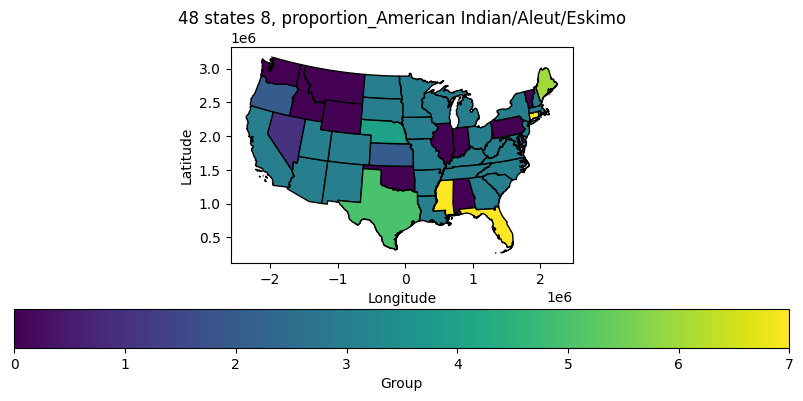

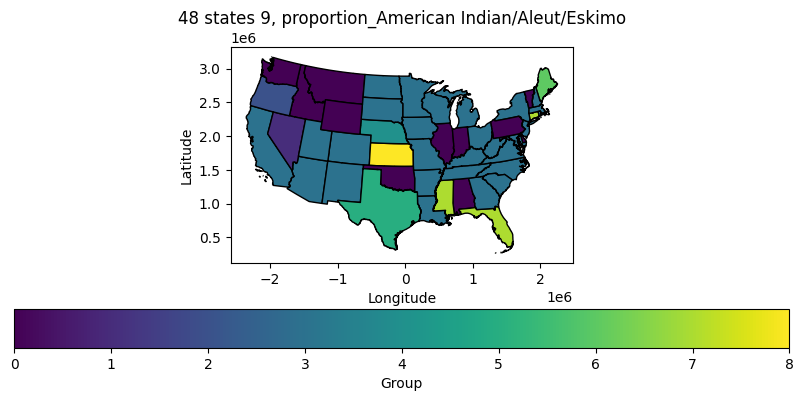

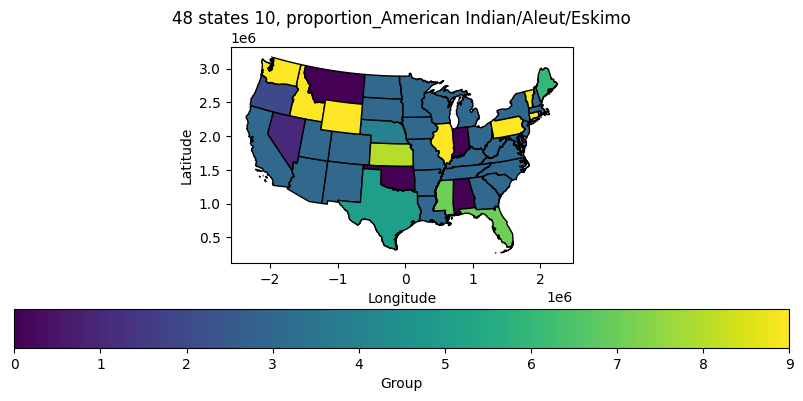

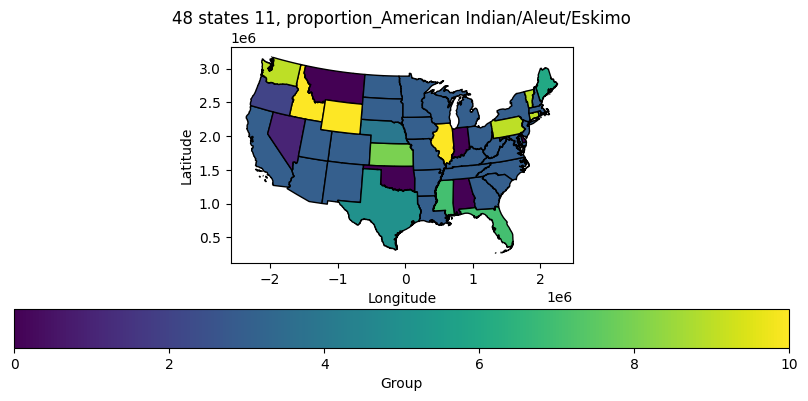

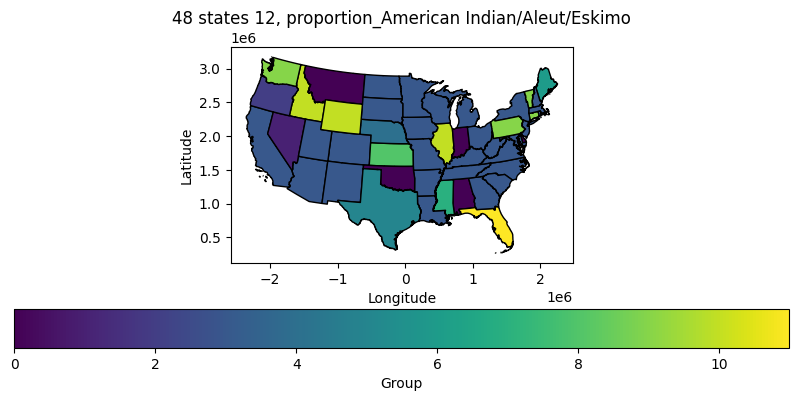

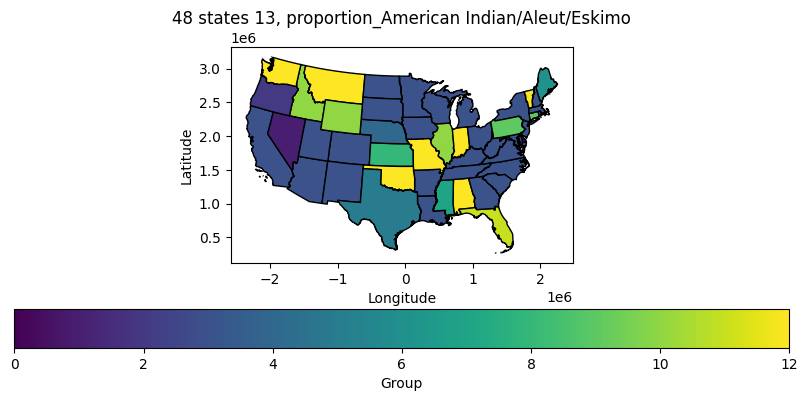

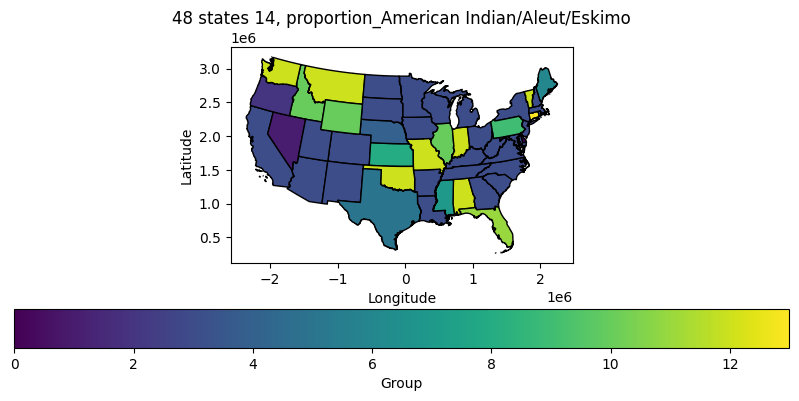

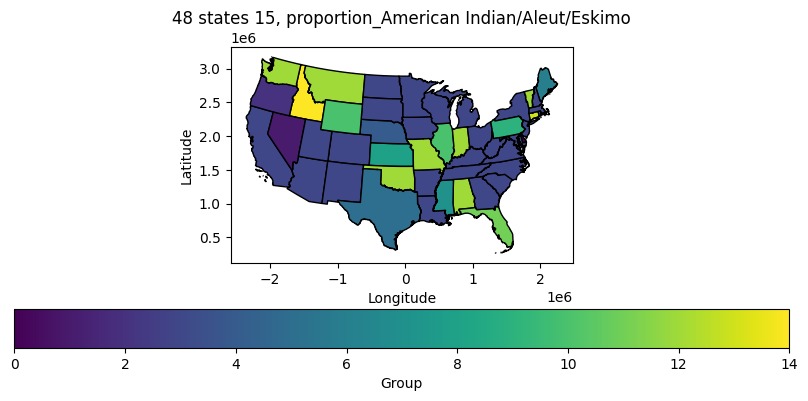

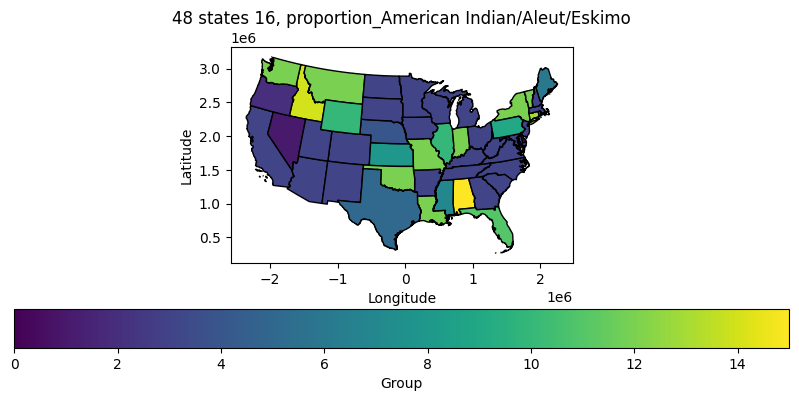

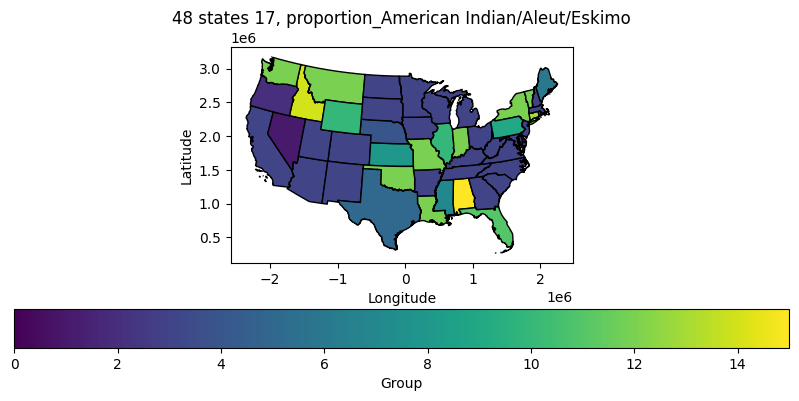

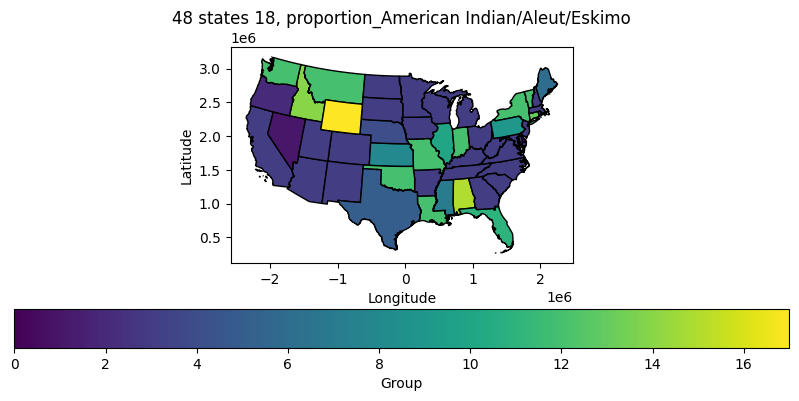

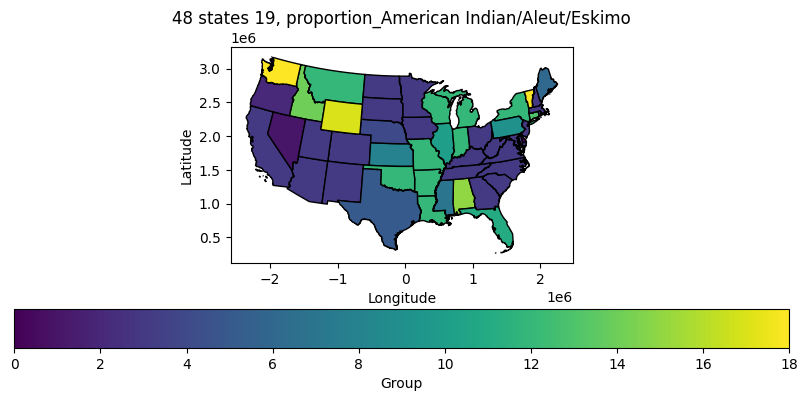

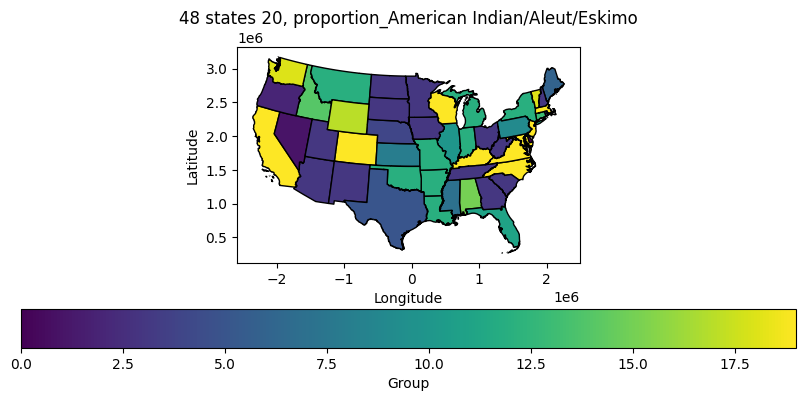

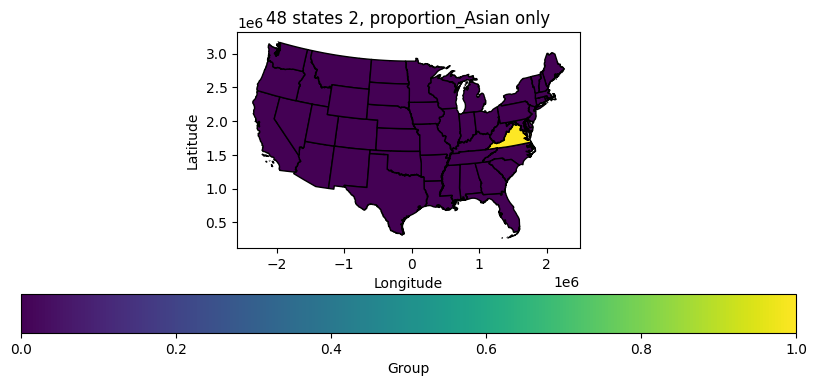

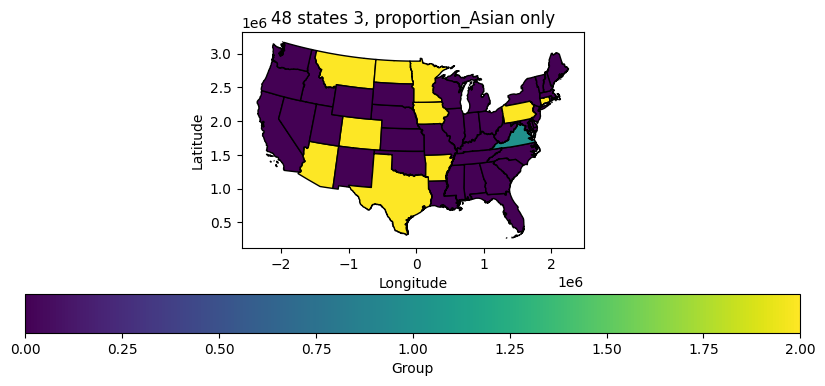

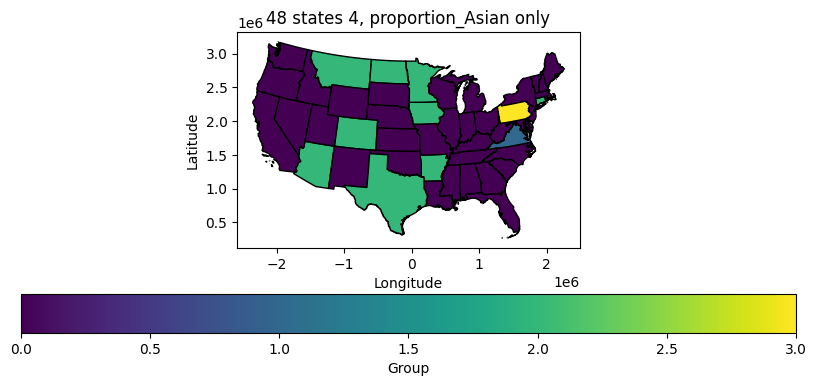

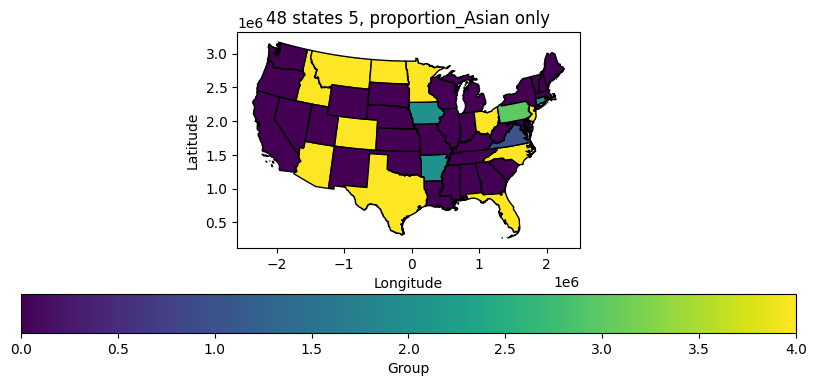

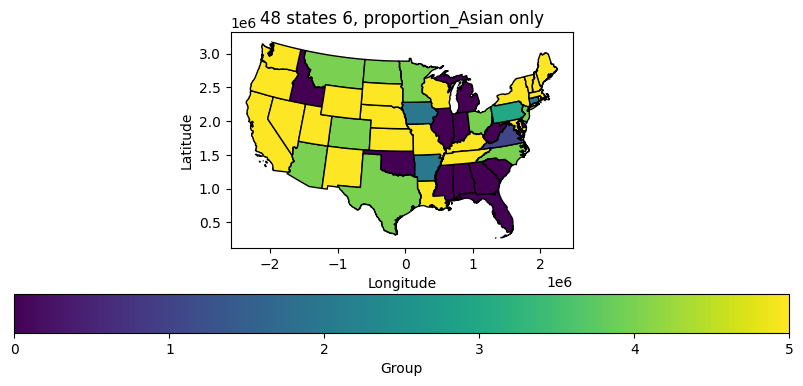

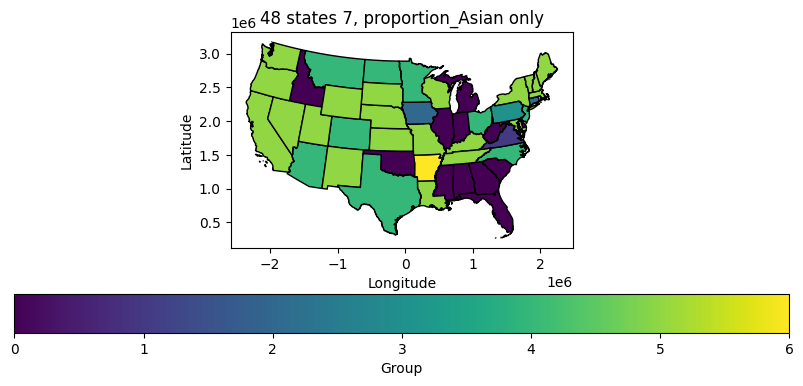

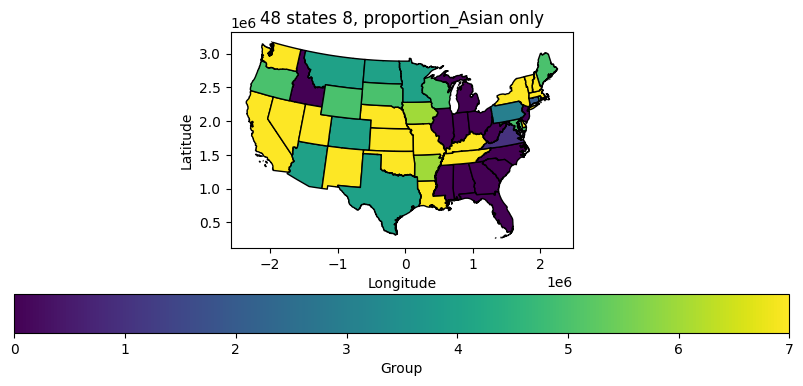

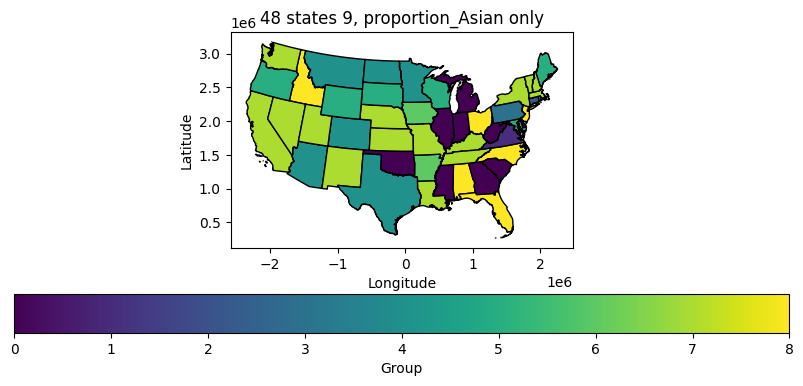

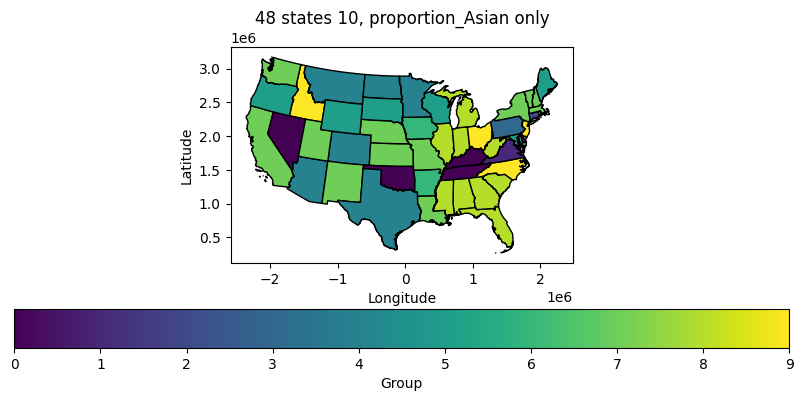

In [ ]:
# for each demographic feature cluster
demo_features = ['proportion_American Indian/Aleut/Eskimo', 'proportion_Asian only', 'proportion_Black', 'proportion_White']

for k in demo_features:
    # get data into correct format
    df_unstacked = data[k].unstack(level='Date')

    for j in range(2, 21):
        # Kmeans with i clusters
        km = TimeSeriesKMeans(n_clusters=j, max_iter=1000, random_state=0)
        pred = km.fit_predict(df_unstacked)

        state_names = df.columns.tolist()[1:]
        plot_df = pd.DataFrame({
            "State": state_names,
            "Number": pred
        })

        # compute cluster
        cluster = {}
        for i in range(j):
            state_with_ = plot_df[plot_df["Number"] == i]["State"]
            cluster[i] = state_with_.values.tolist()

        # Convert group_data to DataFrame
        grouped_states = []
        for group, states in cluster.items():
            for state in states:
                grouped_states.append({'Group': group, 'State': state.lower()})

        grouped_df = pd.DataFrame(grouped_states)
        fips = pd.read_csv('Data_Files/fips.csv')

        # Merge grouped states with their codes
        fips['STATE'] = fips['STATE'].str.lower()
        fips = fips.rename(columns={'STATE': 'State'})
        merged_df = pd.merge(grouped_df, fips, on='State', how='left')
        merged_df['CODE'] = merged_df['CODE'].astype(str).str.zfill(2)
        merged_df = merged_df.rename(columns={'CODE': 'STATEFP'})

        gdf = gpd.read_file("Data_Files/county_data.gpkg")
        gdf = pd.merge(gdf, merged_df, on='STATEFP', how='left')

        # new dataframe that dissolves all counties within each state and drop regions with certain codes
        new_counties = gdf.dissolve(by="STATEFP", aggfunc="first")
        new_counties = new_counties.drop(["02", "15", "60", "66", "69", "72", "78"])
        new_counties.to_crs(5071, inplace=True)
        fig, ax = plt.subplots(1, figsize=(10, 4))
        base = new_counties.plot(column='Group', legend=True, legend_kwds={'label': "Group",
                                            'orientation': "horizontal"}, edgecolor="black", ax=ax, linewidth=1)
        ax.set_title(f"48 states {j}, {k}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        plt.show()